# PaddlePaddle Image Classification with OpenVINO

This demo shows how to run MobileNetV3 Large PaddePaddle model on OpenVINO natively. Instead of exporting the PaddlePaddle model to ONNX and then create the Intermediate Representation (IR) format through OpenVINO optimizer, we can now read direct from the Paddle Model without any conversions.

In [1]:
import os, os.path
import sys
import json
import urllib.request
import cv2
import numpy as np
from scipy.special import softmax

from openvino.inference_engine import IENetwork, IECore, ExecutableNetwork
from IPython.display import Image

def image_preprocess_mobilenetv3(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224,224))
    img = np.transpose(img, [2,0,1]) / 255
    img = np.expand_dims(img, 0)
    img_mean = np.array([0.485, 0.456,0.406]).reshape((3,1,1))
    img_std = np.array([0.229, 0.224, 0.225]).reshape((3,1,1))
    img -= img_mean
    img /= img_std
    return img.astype(np.float32)

def top_k(result, topk=5):
    imagenet_classes = json.loads(open("utils/imagenet_class_index.json").read())
    indices = np.argsort(-result[0])
    for i in range(topk):
        print("Class name:","'"+imagenet_classes[str(indices[0][i])][1]+"'",
              ", probability:", result[0][0][indices[0][i]])

## Download the MobileNetV3_large_x1_0 Model

Here we will direct the pre-trained model directly from the server. More details about the pretrained model can be found in PaddleClas documentation below.

Source: https://github.com/PaddlePaddle/PaddleClas/blob/release/2.2/deploy/lite/readme_en.md

In [2]:
import os.path
import urllib.request
import tarfile

mobilenet_url="https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/inference/MobileNetV3_large_x1_0_infer.tar"
mobilenetv3_model_path = "model/MobileNetV3_large_x1_0_infer/inference.pdmodel"
if os.path.isfile(mobilenetv3_model_path): 
    print("Model MobileNetV3_large_x1_0 already existed")
    
else:
    #Download the model from the server, and untar it.
    print("Downloading the MobileNetV3_large_x1_0_infer model... May take a while...")
    urllib.request.urlretrieve(mobilenet_url, "model/MobileNetV3_large_x1_0_infer.tar")
    print("Model Downloaded")

    file = tarfile.open("model/MobileNetV3_large_x1_0_infer.tar")
    res = file.extractall('model')
    file.close()
    if (res):
        print("Model Extracted to model/MobileNetV3_large_x1_0_infer ")
    else:
        print("Error Extracting the model. Please check the network")

Model MobileNetV3_large_x1_0 already existed


## Run Inference on OpenVINO

Class name: 'Labrador_retriever' , probability: 0.74105805
Class name: 'Staffordshire_bullterrier' , probability: 0.052817777
Class name: 'flat-coated_retriever' , probability: 0.050435282
Class name: 'kelpie' , probability: 0.02938704
Class name: 'schipperke' , probability: 0.012026122


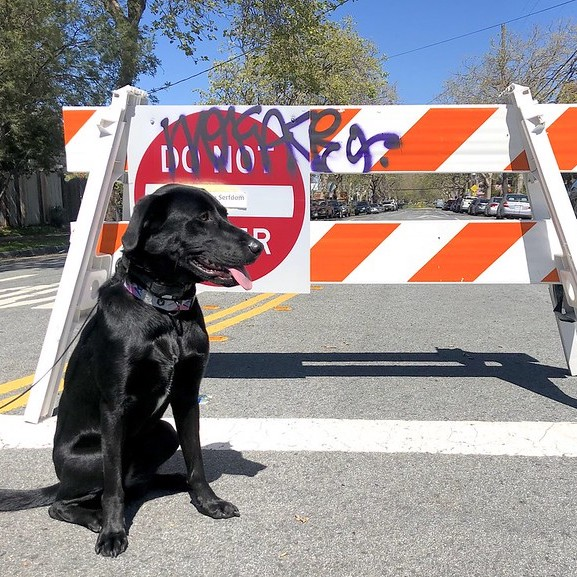

In [3]:
ie = IECore()
#MobileNetV3_large_x1_0
net = ie.read_network("model/MobileNetV3_large_x1_0_infer/inference.pdmodel")

filename = "coco.jpg"
test_image = image_preprocess_mobilenetv3(filename) 

# pdmodel might be dynamic shape, this will reshape based on the input
input_key = list(net.input_info.items())[0][0] # 'inputs'
net.reshape({input_key: test_image.shape})

#load the network on CPU
exec_net = ie.load_network(net, 'CPU') 
assert isinstance(exec_net, ExecutableNetwork)

#perform the inference step
output = exec_net.infer({input_key: test_image})
result_ie = list(output.values())

#filter and print the top 5 results 
top_k(result_ie)
Image(filename=filename) 

IR model in Inference Engine: 0.0034 seconds per image, FPS: 294.86

Class name: 'Labrador_retriever' , probability: 0.74105805
Class name: 'Staffordshire_bullterrier' , probability: 0.052817777
Class name: 'flat-coated_retriever' , probability: 0.050435282
Class name: 'kelpie' , probability: 0.02938704
Class name: 'schipperke' , probability: 0.012026122


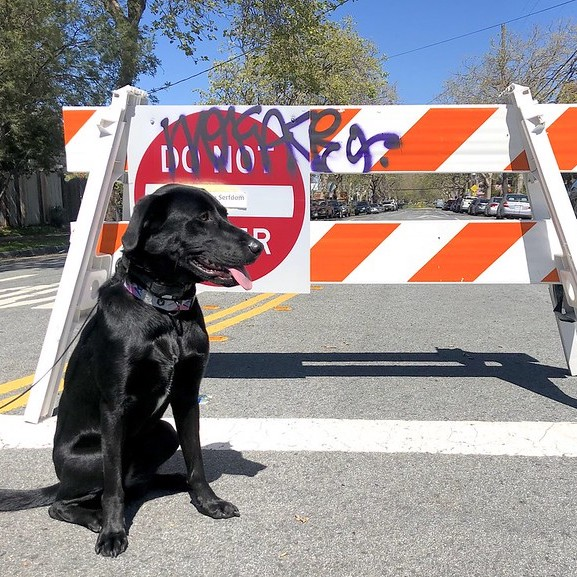

In [4]:
#Run a performance check.
import time

num_images = 500
ie = IECore()
#MobileNetV3_large_x1_0
net = ie.read_network("model/MobileNetV3_large_x1_0_infer/inference.pdmodel")

# pdmodel might be dynamic shape, this will reshape based on the input
input_key = list(net.input_info.items())[0][0] # 'inputs'
net.reshape({input_key: test_image.shape})

#load the network on CPU
exec_net = ie.load_network(net, 'CPU') 
assert isinstance(exec_net, ExecutableNetwork)

#Run inference in a loop
start = time.perf_counter()
for _ in range(num_images):
    #perform the inference step and measure the time
    output = exec_net.infer({input_key: test_image})
end = time.perf_counter()
time_ir = end - start

print(
    f"IR model in Inference Engine: {time_ir/num_images:.4f} "
    f"seconds per image, FPS: {num_images/time_ir:.2f}\n"
)
#filter and print the top 5 results 
result_ie = list(output.values())
top_k(result_ie)
Image(filename=filename) 